In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pycbc.waveform import td_approximants, fd_approximants, get_td_waveform
from pycbc.detector import Detector
from pycbc.filter import match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import timeseries

# Inital plots

In [2]:
print(td_approximants())
print(fd_approximants())

['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'IMRPhenomTP', 'IMRPhenomTPHM', 'SEOBNRv4HM_PA', 'pSEOBNRv4HM_PA', 'IMRPhenomXAS_NRTidalv2', 'IMRPhenomXP_NRTidalv2', 'IMRPhenomXO4a', 'E

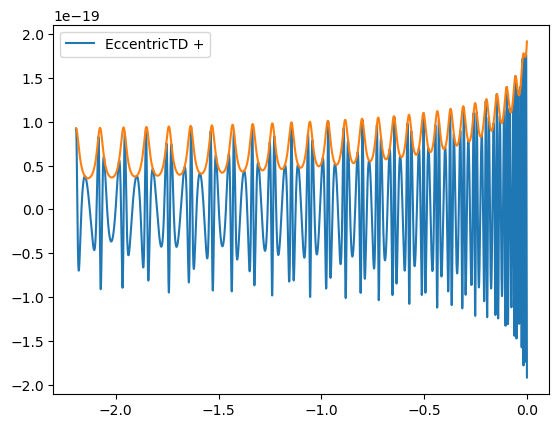

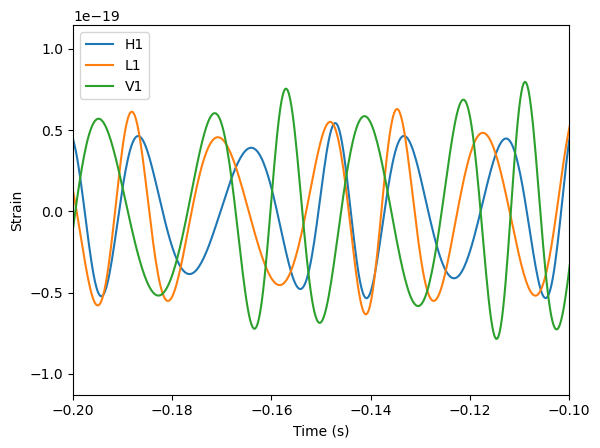

In [11]:
hp, hc = get_td_waveform(approximant='EccentricTD',
                         mass1=20,
                         mass2=10,
                         eccentricity=0.3,
                         delta_t=1.0/4096,
                         f_lower=20)

plt.plot(hp.sample_times, hp, label='EccentricTD +')
plt.plot(hp.sample_times, (hp**2+hc**2)**(1/2))
#plt.plot(hc.sample_times, hc, label='EccentricTD x')
#plt.xlim(-3.5,-3)
plt.legend()

plt.show()

end_time = 1192529720
declination = 0.65
right_ascension = 4.67
polarization = 2.34
hp.start_time += end_time
hc.start_time += end_time

dets = {}
signals = {}
det_names = ['H1', 'L1', 'V1']
for det in det_names:
    dets[det] = Detector(det)
    signals[det] = dets[det].project_wave(hp, hc, right_ascension, declination, polarization)
    plt.plot(signals[det].sample_times - end_time, signals[det], label=det)

plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.xlim(-0.2,-0.1)
plt.legend()

In [ ]:
for mode_select in [None, '22', '33', '21', '32', '44']:
    
    hp, hc = get_td_waveform(approximant="IMRPhenomXPHM",
                             mass1=10,
                             mass2=100,
                             f_lower=20.0,
                             mode_array=mode_select,
                             inclination = np.pi/2,
                             delta_t=1.0/4096)
    
    if mode_select==None:
        mode_select='Full'
    plt.plot(hp.sample_times, hp, label=mode_select)
    
plt.xlim(-0.5,0.1)
#plt.ylim(-1e-19,1e-19)
plt.legend()
plt.show()

# Mass ratio vs relative mode strength

In [ ]:
def progenitor_mass(chirp_m, eta):
    
    total_m = chirp_m*eta**(-3/5)
    q = (1-2*eta + np.sqrt(1-4*eta))/(2*eta)
    m_2 = total_m/(q+1)
    m_1 = total_m - m_2
    
    return m_1, m_2

In [ ]:
chirp_mass = 30
etas = np.arange(0.08,0.26,0.01)
modes = ['22', '33', '21', '32', '44']

rel_strength=[]
for i in range(len(etas)):
    
    rel_strength.append([])
    
    m1, m2 = progenitor_mass(30, etas[i])
    
    fp, fc = get_td_waveform(approximant="IMRPhenomXPHM",
                                 mass1=m1,
                                 mass2=m2,
                                 f_lower=20.0,
                                 inclination = np.pi/2,
                                 delta_t=1.0/4096)
    famp = np.sqrt(fp**2+fc**2)
    finds = np.logical_and(fp.sample_times>=-0.3, fp.sample_times<=0)
    foverall = np.mean(np.abs(famp[finds]))
    
    for mode_select in modes:
    
        hp, hc = get_td_waveform(approximant="IMRPhenomXPHM",
                                 mass1=m1,
                                 mass2=m2,
                                 f_lower=20.0,
                                 mode_array=mode_select,
                                 inclination = np.pi/2,
                                 delta_t=1.0/4096)
        hamp = np.sqrt(hp**2+hc**2)
        hinds = np.logical_and(hp.sample_times>=-0.3, hp.sample_times<=0)
        hoverall = np.mean(np.abs(hamp[hinds]))
        
        rel_strength[i].append(hoverall/foverall)

In [ ]:
for i, mode in enumerate(modes):
    if mode[0]==mode[1]:
        plt.plot(etas, np.array(rel_strength)[:,i], label=mode)
plt.legend()
plt.xlabel('Symmetric mass ratio $\eta$')
plt.ylabel('(rough) relative mode strength')

# Match tests

In [6]:
def ceiltwo(number):
    ceil = math.ceil(np.log2(number))
    return 2**ceil

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


The match is: 0.6471


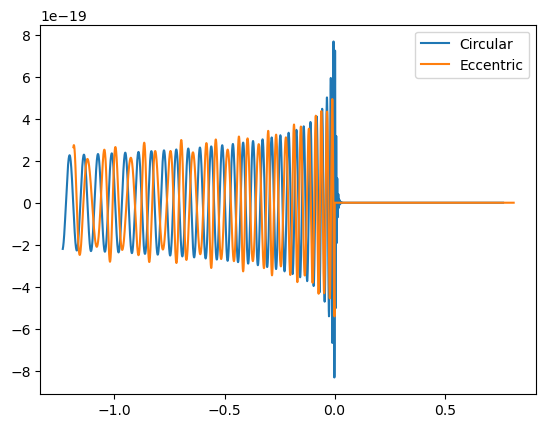

In [7]:
f_low = 15
sample_rate = 4096

# Generate the two waveforms to compare
hp, hc = get_td_waveform(approximant="EccentricTD",
                         mass1=160/3,
                         mass2=80/3,
                         f_lower=f_low,
                         eccentricity=0.1,
                         f_ref=20,
                         delta_t=1.0/sample_rate)

sp, sc = get_td_waveform(approximant="TEOBResumS",
                         mass1=160/3,
                         mass2=80/3,
                         f_lower=f_low,
                         delta_t=1.0/sample_rate)

# modulations = 0.3*np.sin(50*hp.sample_times)+1
# hp *= modulations

# Resize the waveforms to the same length
tlen = ceiltwo(max(len(sp), len(hp)))
sp.resize(tlen)
hp.resize(tlen)
sc.resize(tlen)
hc.resize(tlen)

plt.plot(sp.sample_times, sp, label='Circular')
plt.plot(hp.sample_times, hp, label='Eccentric')
plt.legend()
#plt.xlim(-1,0.1)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / sp.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low, subsample_interpolation=True)
print('The match is: {:.4f}'.format(m))

The match is: 0.9545


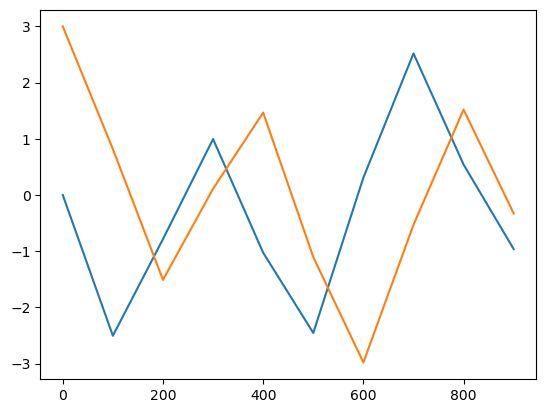

In [4]:
x = np.arange(0,1000,100)

test_match1 = timeseries.TimeSeries(np.sin(x)+2*np.sin(3*x), 1)
test_match2 = timeseries.TimeSeries(np.cos(x)+2*np.cos(3*x), 1)
m, i = match(test_match1, test_match2, subsample_interpolation=False)
print('The match is: {:.4f}'.format(m))

plt.plot(x, test_match1)
plt.plot(x, test_match2)